### doc_entity
ESTABELECE RELAÇÕES ENTRE DOCUMENTOS E ENTIDADES NA BASE DE DADOS NO MYSQL. TRABALHAMOS COM O ACERVO **ANTONIO AZEREDO DA SILVEIRA, MINISTÉRIO DAS RELAÇÕES EXTERIORES**.  

AS ENTIDADES A SEREM TRABALHADAS SÃO:
* PAÍSES
* PESSOAS

In [1]:
import os
import sys
import time
import datetime
import numpy as np
import pandas as pd
import re

#import pymysql
import getpass
#from sshtunnel import SSHTunnelForwarder

from IPython.display import clear_output

import csv
import xlrd
import xlwt

import unicodedata
import numpy as np
from wordcloud import WordCloud, STOPWORDS
from collections import OrderedDict, Counter
import codecs
import string
import nltk
import networkx as nx
import matplotlib.pyplot as plt

In [2]:
outputs = 'C:/Users/MARCELO/Dropbox/A-Marcelo/Educação-Trabalho/2016-CPDOC/textfiles-original-renamed-test/'
outputs = 'C:/Users/marcelo.ribeiro/Dropbox/A-Marcelo/Educação-Trabalho/2016-CPDOC/textfiles-original-renamed-test/'
datapath = 'C:/Users/marcelo.ribeiro/Dropbox/A-Marcelo/Educação-Trabalho/2016-CPDOC/textfiles-original-renamed-test/'
oplexicon = 'C:/Users/marcelo.ribeiro/Dropbox/A-Marcelo/Educação-Trabalho/2017-EMAP/curso-python/MMD-master/datasets/oplexicon_v3.0/lexico_v3.0.txt'

In [3]:
corpuspath = os.path.join(outputs)
onlyfiles = [f for f in os.listdir(corpuspath) if os.path.isfile(os.path.join(corpuspath,f)) and not f.startswith('.')]

In [4]:
'''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''
define pastas de trabalho
'''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''

path = "C:/Users/MARCELO/Dropbox/A-Marcelo/Educação-Trabalho/2016-CPDOC/Azeredo Papers/Processamento/text-learning-tools/inputs/"
path = "C:/Users/marcelo.ribeiro/Dropbox/A-Marcelo/Educação-Trabalho/2016-CPDOC/Azeredo Papers/Processamento/text-learning-tools/inputs/"

#### Abre arquivo XLS

In [5]:
workbook = xlrd.open_workbook(path+'PESSOAS-do-Accessus.xls', on_demand = True)

#worksheet = workbook.sheet_by_index(0)
worksheet = workbook.sheet_by_name('Rel_DescritorEleito')

WARNING *** file size (1367936) not 512 + multiple of sector size (512)


Captura nomes de entidades pessoas retiradas da base do Accessus/CPDOC

In [6]:
exceptions_list = ['a.', 'i.', 'j.', 'de']

In [7]:
def strip_accents(s):
   return ''.join(c for c in unicodedata.normalize('NFD', s)
                  if unicodedata.category(c) != 'Mn')

In [8]:
names_list = []

for line in range(worksheet.nrows):
    number_name = str(worksheet.cell(line, 0).value)
    check_number = re.search('^\d',number_name)
    if check_number is not None:
        if line == worksheet.nrows-1: break
        fullname = str(worksheet.cell(line, 1).value)
        fullname = str.lower(fullname)
        fullname_split = fullname.split()
        for name in fullname_split: 
            if name not in exceptions_list and name not in names_list:
                alt_name = strip_accents(name)
                names_list.append(name)
                if alt_name != name: names_list.append(alt_name) 

In [9]:
names_list[:10]

['castro',
 'lima',
 'saldanha',
 'júnior',
 'junior',
 'azevedo',
 'faria',
 'peixoto',
 'pinto',
 'ferraz']

In [10]:
#teste
text_test_list = ''
names_list_test = ['geisel', 'azeredo', 'ernesto', 'antonio']
text_test1 = 'O ministro antonio azeredo assinou o tratado. Já o presidente ernesto geisel não concordou com a atitude de azeredo'
text_test2 = 'O ministro antonio azeredo é contra tecnologia nuclear. Já o presidente ernesto geisel defende acordo com alemanha ocidental'
text_test_list = text_test1 + text_test2

#text_test.count(names_list_test[0])

In [11]:
additional_words = ['assinou']

stopwords = nltk.corpus.stopwords.words('english') + \
            nltk.corpus.stopwords.words('portuguese') + \
            nltk.corpus.stopwords.words('french') + \
            nltk.corpus.stopwords.words('spanish') + \
            nltk.corpus.stopwords.words('german') + \
            additional_words

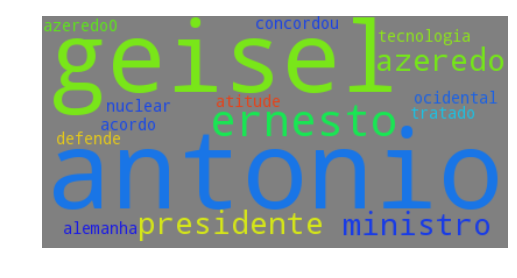

In [12]:
#basic test with wordcloud. See also: https://github.com/amueller/word_cloud
#text = 'all your base are belong to us all of your base base base' # for basic testing
wordcloud = WordCloud(background_color="gray", max_words=50, relative_scaling = 1.0,stopwords = stopwords)
wordcloud.generate(text_test_list)
plt.imshow(wordcloud)
plt.axis("off")
plt.show()

In [13]:
df_o = pd.read_csv(os.path.join(datapath,oplexicon), header=None, encoding='utf-8', usecols=[0,2], names=[u'palavra',u'polaridade'])
df_o.drop_duplicates(subset=[u'palavra'], take_last=False, inplace=True)
df_o = df_o.set_index(u'palavra')
print(u'Corpus com {} palavras polarizadas'.format(len(df_o)))

Corpus com 32119 palavras polarizadas


C:\Anaconda3\lib\site-packages\ipykernel\__main__.py:2: FutureWarning: the take_last=False keyword is deprecated, use keep='first' instead
  from ipykernel import kernelapp as app


In [14]:
def polariza_counter(dicionario, df1):
    polaridades = []
    fator_div = 0
    ausentes = []
    for palavra, frequencia in dicionario.items():
        p = palavra.lower().strip()
        if p in df1.index:
            polaridades.append(df1.polaridade[p] * frequencia)
            fator_div += frequencia
        else:
            ausentes.append((palavra,frequencia))
    num_pal = len(dicionario)
    num_pol = len(polaridades)
    razao_pol = num_pol/float(num_pal) if num_pal else 0.0
    polaridade = sum(polaridades)/float(fator_div)
    print('Foram polarizadas {} palavras de um total de {} ({:.2%})'.format(num_pol, num_pal, razao_pol))
    print('A polaridade mensurada do texto é de {:.3}'.format(polaridade))
    return polaridade, ausentes

Vamos agora construir um grafo de palavras para estudar co-ocorrências nos textos dos feeds
Abordagem e funções aproveitadas de https://github.com/ipython/talks/blob/master/notebook/text_utils.py

In [15]:
ignore_words = [w for w in nltk.corpus.stopwords.words('portuguese')]
ignore_expressions = ['o', 'a', '']

In [16]:
raw_texts = ''
list_raw_texts = []
for filename in onlyfiles:
    page_txt = codecs.open(os.path.join(corpuspath,filename), encoding='utf-8').read()
    raw_texts += u'\n'+ page_txt.lower()
    list_raw_texts.append(page_txt)
#teste
list_raw_texts = [text_test1, text_test2]
len(list_raw_texts)

2

In [17]:
print(raw_texts[0:140])


l"

»,

aa5_qqqa._os.4'5
aqupn

  

. ;jl'|.x7_v)«x .,: qm, lux . .“,i'í 'nzuvs .»,v »; c.n';:a.:«_'-x um uw —'

brasilia - df,
ayiso n? 27


In [18]:
def corrige_distorcoes(texto):
    texto = texto.replace(u'\xe0', u'a a') #separa o a com crase
    texto = texto.replace(u'\u201c', '') #retira um certo tipo de aspas
    texto = texto.replace(u'\u201d', '') #retira um certo tipo de aspas
    texto = texto.replace(u'\u2018', '') #retira um certo tipo de aspas
    texto = texto.replace(u'\u2019', '') #retira um certo tipo de aspas
    texto = texto.replace(u'get\xfalio vargas', u'getulio vargas') #homogeniza as formas de Getulio Vargas
    return texto

def limpa_stopwords(texto):
    for expression in ignore_expressions:
        texto = texto.replace(expression.lower(),'') #retira as expressoes
    lista = [w.strip(string.punctuation) for w in texto.split() if w.strip(string.punctuation) not in ignore_words] #retira stopw.
    texto = u' '.join(lista)
    return texto, lista

In [19]:
#list_cleaned_words = limpa_stopwords(raw_texts)
#teste
raw_texts = corrige_distorcoes(raw_texts)
cleaned_texts, list_cleaned_words = limpa_stopwords(raw_texts)

In [20]:
print(list_cleaned_words[0:200])

['l', '»', "5_qqq._s.4'5", 'qupn', '', "jl'|.x7_v)«x", '', 'qm', 'lux', '', "i'í", 'nzuvs', '»,v', '»', "c.n';:.:«_'-x", 'uw', '—', 'brsili', '', 'df', 'yis', 'n', '274/74', '15', 'gst', '1974', 'senhr', 'ministr', 'tenh', 'hnr', 'dirigir-me', 'vss', 'excelênci', 'reg', 'peit', 'd', 'infrmçã', 'n', 'lbl-secret', '29', 'julh', '1974,deg', 'ministéri', 'ssunt', 'cntid', 'n', 'referid', 'dcument', 'vers', 'sbre', 'cperçã', 'n', 'cmp', 'industril', 'ds', 'tividdes', 'ligds', 'prº', 'veitment', 'd', 'energi', 'nucler', 'brsil', 'repúblic', 'fe—', 'derl', 'd', 'lemnh', 'deu', 'rigem', 'ã', 'expsiçã', 'mtivs', 'n', '055/74', '13', 'gst', '1974', 'dest', 'secretri—gerl', 'n', 'qul', 'excelentíssim', 'senhr', 'presidente', 'd', 'repúblic', 'deu', 'seguinte', 'desp—', 'ch', '', '', 'prv', '13', 'g', '74', 'dnd', 'cumpriment', 'ã', 'determinçã', 'presidencil', 'pss', 's', 'mãs', 'vss', 'excelênci', 'cõpi', 'd', 'citd', 'expsiçã', 'mtivs', '', 'prveit', 'prtunidde', 'pr', 'renvr', 'vss', 'exce—', 

In [23]:
freq_words = Counter(list_cleaned_words)
series_freq_words = pd.Series(data=freq_words, index=freq_words.keys())
#df_freq_words = pd.DataFrame(series_freq_words, columns = ['Frequência'], index=freq_words.keys())
df_freq_words = pd.DataFrame(series_freq_words, columns = ['Frequência'])
df_freq_words = df_freq_words.sort_values(by='Frequência', ascending=False)
df_freq_words.index.name = 'Tokens'
df_freq_words[0:40]

,Frequência
Tokens,
,166
d,137
n,59
s,55
pr,43
cm,41
ds,32
—,26
energi,20


In [25]:
polariza_counter(freq_words, df_o);

Foram polarizadas 23 palavras de um total de 1441 (1.60%)
A polaridade mensurada do texto é de -0.0323


In [26]:
def print_vk(lst):
    """Print a list of value/key pairs nicely formatted in key/value order."""

    # Find the longest key: remember, the list has value/key pairs, so the key
    # is element [1], not [0]
    longest_key = max([len(word) for word, count in lst])
    # Make a format string out of it
    fmt = '%'+str(longest_key)+'s -> %s'
    # Do actual printing
    for k,v in lst:
        print (fmt % (k,v))
    print('\n')

In [27]:
def plot_word_histogram(freqs, show=10, title=None):
    """Plot a histogram of word frequencies, limited to the top <show> ones.
    """
    sorted_f = sort_freqs(freqs) if isinstance(freqs, dict) else freqs

    # Don't show the tail
    if isinstance(show, int):
        # interpret as number of words to show in histogram
        show_f = sorted_f[-show:]
    else:
        # interpret as a fraction
        start = -int(round(show*len(freqs)))
        show_f = sorted_f[start:]

    # Now, extract words and counts, plot
    n_words = len(show_f)
    ind = np.arange(n_words)
    words = [i[0] for i in show_f]
    counts = [i[1] for i in show_f]

    fig = plt.figure(figsize=(8,8))
    ax = fig.add_subplot(111)

    if n_words<=20:
        # Only show bars and x labels for small histograms, they don't make
        # sense otherwise
        ax.bar(ind, counts)
        ax.set_xticks(ind)
        ax.set_xticklabels(words, rotation=45)
        fig.subplots_adjust(bottom=0.25)
    else:
        # For larger ones, do a step plot
        ax.step(ind, counts)

    # If it spans more than two decades, use a log scale
    if float(max(counts))/min(counts) > 100:
        ax.set_yscale('log')

    if title:
        ax.set_title(title)
    return ax

In [62]:
number_words=15      
w_items = freq_words.items()
w_items = list(w_items)
w_items.sort(key = lambda wc: wc[1])
print ('Number of unique words:',len(w_items))
#print('{} least frequent words:').format(number_words)
#print_vk(w_items[:10])
#print('{} most frequent words:').format(number_words)
print_vk(w_items[:-10:-1])
plot_word_histogram(w_items, number_words,'Frequencies for {} most frequent words'.format(number_words));

Number of unique words: 1441
       -> 166
     d -> 137
     n -> 59
     s -> 55
    pr -> 43
    cm -> 41
    ds -> 32
     — -> 26
energi -> 20




In [129]:
def all_pairs(items):
    """Make all unique pairs (order doesn't matter)"""
    pairs = []
    nitems = len(items)
    for i, wi in enumerate(items):
        for j in range(i+1, nitems):
            pairs.append((wi, items[j]))
    return pairs

def co_occurrences(lines, words):
    """Return histogram of co-occurrences of words in a list of lines.

    Parameters
    ----------
    lines : list
      A list of strings considered as 'sentences' to search for co-occurrences.

    words : list
      A list of words from which all unordered pairs will be constructed and
      searched for co-occurrences.
    """
    wpairs = all_pairs(words)

    # Now build histogram of co-occurrences
    co_occur = {}
    for w1, w2 in wpairs:
        rx = re.compile('%s .*%s|%s .*%s' % (w1, w2, w2, w1))
        co_occur[w1, w2] = sum([1 for line in lines if rx.search(line)])

    return co_occur

def co_occurrences_graph(word_hist, co_occur, cutoff=0):
    """Convert a word histogram with co-occurrences to a weighted graph.
    Edges are only added if the count is above cutoff.
    """
    g = nx.Graph()
    for word, count in word_hist:
        g.add_node(word, count=count)
    for (w1, w2), count in co_occur.items():
        if count<=cutoff:
            continue
        g.add_edge(w1, w2, weight=count)
    return g

In [63]:
n_nodes = 15
popular = w_items[-n_nodes:]
pop_words = [wc[0] for wc in popular]
co_occur = co_occurrences(list_raw_texts, pop_words)
wgraph = co_occurrences_graph(popular, co_occur, cutoff=1)
wsubgraph = list(nx.connected_component_subgraphs(wgraph))[1] #we have to choose the biggest con. comp.
centrality = nx.eigenvector_centrality_numpy(wsubgraph)
c = centrality.items()
c.sort(key=lambda x:x[1], reverse=True)
print ('\nGraph centrality')
for node, cent in c:
    print ("%15s: %.3g" % (node, float(cent)))

NameError: name 'co_occurrences' is not defined

In [131]:
count = np.array(freq_words.values())
words = np.array(freq_words.keys())
#count = count.astype(int)
make_wordcloud(words, count, 'test.png')
Image(filename='test.png', width=640, height=480)

NameError: name 'make_wordcloud' is not defined

In [132]:
print(type(count))

<class 'numpy.ndarray'>


In [133]:
print(type(count[0]))

IndexError: too many indices for array

In [64]:
def all_pairs(items):
    """Make all unique pairs (order doesn't matter)"""
    pairs = []
    nitems = len(items)
    for i, wi in enumerate(items):
        for j in range(i+1, nitems):
            pairs.append((wi, items[j]))
    return pairs

def co_occurrences(lines, words):
    """Return histogram of co-occurrences of words in a list of lines.

    Parameters
    ----------
    lines : list
      A list of strings considered as 'sentences' to search for co-occurrences.

    words : list
      A list of words from which all unordered pairs will be constructed and
      searched for co-occurrences.
    """
    wpairs = all_pairs(words)

    # Now build histogram of co-occurrences
    co_occur = {}
    for w1, w2 in wpairs:
        rx = re.compile('%s .*%s|%s .*%s' % (w1, w2, w2, w1))
        co_occur[w1, w2] = sum([1 for line in lines if rx.search(line)])

    return co_occur

def co_occurrences_graph(word_hist, co_occur, cutoff=0):
    """Convert a word histogram with co-occurrences to a weighted graph.
    Edges are only added if the count is above cutoff.
    """
    g = nx.Graph()
    for word, count in word_hist:
        g.add_node(word, count=count)
    for (w1, w2), count in co_occur.items():
        if count<=cutoff:
            continue
        g.add_edge(w1, w2, weight=count)
    return g

In [65]:
n_nodes = 15
popular = w_items[-n_nodes:]
pop_words = [wc[0] for wc in popular]
co_occur = co_occurrences(list_raw_texts, pop_words)
wgraph = co_occurrences_graph(popular, co_occur, cutoff=1)
wsubgraph = list(nx.connected_component_subgraphs(wgraph))[1] #we have to choose the biggest con. comp.
centrality = nx.eigenvector_centrality_numpy(wsubgraph)
c = centrality.items()
c.sort(key=lambda x:x[1], reverse=True)
print ('\nGraph centrality')
for node, cent in c:
    print ("%15s: %.3g" % (node, float(cent)))

ValueError: k=1 must be between 1 and ndim(A)-1=0

In [59]:
rad0 = 0.2
def rescale_arr(arr, amin, amax):
    """Rescale an array to a new range.
    Return a new array whose range of values is (amin, amax).
    Parameters
    ----------
    arr : array-like
    amin : float
      new minimum value
    amax : float
      new maximum value

    Examples
    --------
    >>> a = np.arange(5)
    >>> rescale_arr(a,3,6)
    array([ 3.  ,  3.75,  4.5 ,  5.25,  6.  ])
    """
    # old bounds
    m = arr.min()
    M = arr.max()
    # scale/offset
    s = float(amax-amin)/(M-m)
    d = amin - s*m

    # Apply clip before returning to cut off possible overflows outside the
    # intended range due to roundoff error, so that we can absolutely guarantee
    # that on output, there are no values > amax or < amin.
    return np.clip(s*arr+d,amin,amax)

def plot_graph(wgraph, pos=None, fig=None, title=None):
    """Conveniently summarize graph visually"""

    # config parameters
    edge_min_width= 3
    edge_max_width= 12
    label_font = 16
    node_font = 18
    node_alpha = 0.4
    edge_alpha = 0.55
    edge_cmap = plt.cm.Spectral

    # Create figure
    if fig is None:
        fig, ax = plt.subplots()
    else:
        ax = fig.add_subplot(111)
    fig.subplots_adjust(0,0,1)

    # Plot nodes with size according to count
    sizes = []
    degrees = []
    for n, d in wgraph.nodes_iter(data=True):
        sizes.append(d['count'])
        degrees.append(wgraph.degree(n))

    sizes = rescale_arr(np.array(sizes, dtype=float), 100, 1000)

    # Compute layout and label edges according to weight
    pos = nx.spring_layout(wgraph) if pos is None else pos
    labels = {}
    width = []
    for n1, n2, d in wgraph.edges_iter(data=True):
        w = d['weight']
        labels[n1, n2] = w
        width.append(w)

    width = rescale_arr(np.array(width, dtype=float), edge_min_width, 
                        edge_max_width)

    # Draw
    nx.draw_networkx_nodes(wgraph, pos, node_size=sizes, node_color=degrees,alpha=node_alpha)
    nx.draw_networkx_edges(wgraph, pos, width=width, edge_color=width, edge_cmap=edge_cmap, alpha=edge_alpha)
    nx.draw_networkx_edge_labels(wgraph, pos, edge_labels=labels,font_size=label_font)
    nx.draw_networkx_labels(wgraph, pos, font_size=node_font, font_weight='bold')
    if title is not None:
        ax.set_title(title, fontsize=label_font)
    ax.set_xticks([])
    ax.set_yticks([])

    # Mark centrality axes
    kw = dict(color='k', linestyle='-')
    cross = [ax.axhline(0, **kw), ax.axvline(rad0, **kw)]
    [ l.set_zorder(0) for l in cross]
    
def centrality_layout(wgraph, centrality):
    """Compute a layout based on centrality.
    """
    # Create a list of centralities, sorted by centrality value
    cent = sorted(centrality.items(), key=lambda x:float(x[1]), reverse=True)
    nodes = [c[0] for c in cent]
    cent  = np.array([float(c[1]) for c in cent])
    rad = (cent - cent[0])/(cent[-1]-cent[0])
    rad = rescale_arr(rad, rad0, 1)
    angles = np.linspace(0, 2*np.pi, len(centrality))
    layout = {}
    for n, node in enumerate(nodes):
        r = rad[n]
        th = angles[n]
        layout[node] = r*np.cos(th), r*np.sin(th)
    return layout

In [60]:
print ("Graph visualization for query:")
plot_graph(wsubgraph, centrality_layout(wsubgraph, centrality), 
           plt.figure(figsize=(12,12)), 
           title = u'Centrality and term co-occurrence graph, q="{}"'.format(query))

Graph visualization for query:


NameError: name 'wsubgraph' is not defined

### Inserção na base de dados

##### ENTIDADE: PESSOA

Alimenta a tabela person_doc, da nossa base no mysql, fazendo interseção de dados da tabela persons com a tabela docs.

In [12]:
'''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''
alimenta a a tabela person_doc, da nossa base no mysql.
'''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''
count = 0
#percentil = int(len(cursor.rowcount/100)

pass_sshkey = getpass.getpass()
pass_mysql = getpass.getpass()
with SSHTunnelForwarder(('200.20.164.147', 22),
                        ssh_private_key = "C:/Users/marcelo.ribeiro/Dropbox/A-Marcelo/Educação-Trabalho/2016-CPDOC/Remoto/marcelo_priv_rsa",
                        #ssh_private_key = '/home/rsouza/.ssh/id_rsa',
                        ssh_private_key_password = pass_sshkey,
                        ssh_username="marcelobribeiro",
                        #ssh_username="rsouza",
                        remote_bind_address=('127.0.0.1', 3306)) as server:
    
    conn = pymysql.connect(host='localhost', 
                           port=server.local_bind_port, 
                           user='marcelobribeiro', 
                           #user='rsouza',
                           passwd=pass_mysql,
                           db='CPDOC_AS',
                           use_unicode=True, 
                           charset="utf8")
    cur = conn.cursor()
    '''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''
    insere dados na base mysql
    captura documentos da tabela docs, transfere para a tabela topic-doc e insere dados de tópicos
    '''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''
    
    cur.execute("DROP TABLE IF EXISTS person_doc")
    cur.execute('''CREATE TABLE IF NOT EXISTS person_doc 
               (person_id INT(11), doc_id VARCHAR(31), person_count BIGINT(21)
               DEFAULT NULL)
               ENGINE=MyISAM DEFAULT CHARSET='utf8';''')

    cur.execute("SELECT id,body FROM CPDOC_AS.docs")
    data = cur.fetchall()
    for row in data:
        count += 1 # for break event
        if row is None: break
        text_id = row[0]
        text =  row[1]
        #text = text.split()
        doc_id = row[0]
        for name in names_list_test:
            person_id = 1
            person_count = text.count(name)
            query = "INSERT INTO person_doc VALUES (%s, %s, %s)"
            cur.execute(query, (person_id, doc_id, person_count))
        print(name, 'text_id', text_id)
        #print(doc_id, topic_id, topic_score)   
        cur.execute("ALTER TABLE person_doc ORDER BY doc_id ASC, person_count DESC")
        
        if count == 10: break #amostra de apenas 10 linhas

········
········
azeredo text_id rb_1974.04.17_doc_I-66
azeredo text_id onu_1974.03.12_doc_II-49
azeredo text_id onu_1974.03.12_doc_V-2
azeredo text_id be_1974.04.16_doc_VI-18
azeredo text_id be_1977.06.01_doc_II-21
azeredo text_id ag_1974.03.13_doc_III-7
azeredo text_id ag_1973.11.20_doc_VI-75
azeredo text_id d_1974.04.23_doc_XXXII-8
azeredo text_id d_1974.03.26_doc_XXXII-32
azeredo text_id d_1974.03.26_doc_XXII-9


##### ENTIDADE: LUGAR (PAÍS)

Alimenta a a tabela country_doc, da nossa base no mysql, fazendo interseção de dados da tabela countries com a tabela docs.